In [25]:
import numpy as np
import cv2
from PIL import Image
from skimage.morphology import skeletonize
from skimage import img_as_bool, io, color
from skimage.morphology import skeletonize, binary_erosion
from skimage import img_as_bool, io, color
from skimage.measure import label, regionprops
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt
from skimage.filters import gabor
from skimage.morphology import thin
import os
import math

In [26]:
def preprocess_image(image_path):
    # Load the image in grayscale mode
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Apply a 3x3 median filter for noise removal
    denoised_image = cv2.medianBlur(image, 3)

    # Apply Otsu's thresholding for binarization
    _, binarized_image = cv2.threshold(denoised_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    return binarized_image


# Load the original image
image_path = 'w0001_s01_plND_r01.png'
original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Preprocess the image
preprocessed_image = preprocess_image(image_path)

In [4]:
## get feature white black pixels percentage

def crop_center(img, cropx, cropy):
    y, x = img.shape
    startx = x//2 - cropx//2
    starty = y//2 - cropy//2    
    return img[starty:starty+cropy, startx:startx+cropx]

def calculate_pixel_percentages(img, m):
    # grayscale
    #img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Crop the image to a square of width m
    cropped_img = crop_center(img, m, m)
    
    # Calculate the number of black and white pixels
    black_pixels = np.sum(cropped_img < 128)  # Assuming black if pixel value < 128
    white_pixels = np.sum(cropped_img >= 128)  # Assuming white if pixel value >= 128
    
    # Calculate percentages
    total_pixels = m * m
    percentage_black_pixels = (black_pixels / total_pixels) * 100
    percentage_white_pixels = (white_pixels / total_pixels) * 100
    
    return black_pixels, white_pixels, percentage_black_pixels, percentage_white_pixels

# Example usage
m = 100  # Or whatever the empirical value is for your dataset
features = calculate_pixel_percentages(preprocessed_image, m)
print("Black Pixels:", features[0], "White Pixels:", features[1])
print("Percentage Black Pixels:", features[2], "Percentage White Pixels:", features[3])


Black Pixels: 671 White Pixels: 9329
Percentage Black Pixels: 6.710000000000001 Percentage White Pixels: 93.28999999999999


In [20]:
def crop_center(img, cropx, cropy):
    y, x = img.shape
    startx = x//2 - cropx//2
    starty = y//2 - cropy//2    
    return img[starty:starty+cropy, startx:startx+cropx], (startx, starty, cropx, cropy)

import cv2
import numpy as np

def random_crop(img, cropx, cropy):
    y, x = img.shape
    if x < cropx or y < cropy:
        return None, None  # Image is too small for the desired crop size
    startx = np.random.randint(0, x - cropx)
    starty = np.random.randint(0, y - cropy)
    return img[starty:starty+cropy, startx:startx+cropx], (startx, starty)

def calculate_pixel_percentages(img, m, n):
    # Initialize totals
    total_black_pixels = 0
    total_white_pixels = 0
    samples_counted = 0
    
    for _ in range(n * 10):  # Attempt up to n * 10 times to find n valid samples
        cropped_img, _ = random_crop(img, m, m)
        if cropped_img is None:  # If the image is too small for the crop, skip
            continue
        black_pixels = np.sum(cropped_img < 128)  # Assuming black if pixel value < 128
        white_pixels = np.sum(cropped_img >= 128)  # Assuming white if pixel value >= 128
        if black_pixels:  # Only consider the sample if there are some black pixels
            total_black_pixels += black_pixels
            total_white_pixels += white_pixels
            samples_counted += 1
            if samples_counted == n:  # Break the loop once we have enough samples
                break
    
    # Adjust calculation to reflect the actual number of samples collected
    total_pixels = m * m * samples_counted
    percentage_black_pixels = (total_black_pixels / total_pixels) * 100 if total_pixels else 0
    percentage_white_pixels = (total_white_pixels / total_pixels) * 100 if total_pixels else 0
    
    return total_black_pixels, total_white_pixels, percentage_black_pixels, percentage_white_pixels

m = 100  # size of the square to analyze
n = 100  # number of random samples
features = calculate_pixel_percentages(preprocessed_image, m, n)

print("Total Black Pixels:", features[0], "Total White Pixels:", features[1])
print("Percentage Black Pixels:", features[2], "Percentage White Pixels:", features[3])


Total Black Pixels: 47406 Total White Pixels: 952594
Percentage Black Pixels: 4.7406 Percentage White Pixels: 95.2594


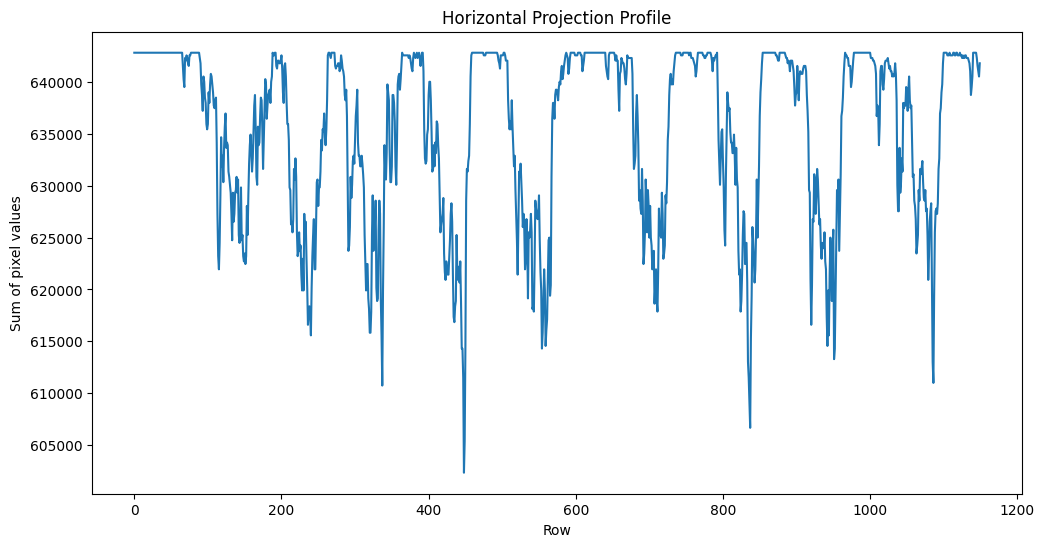

Peaks at rows: [  69   71   94  101  104  111  118  120  124  126  134  139  141  145
  147  150  153  158  164  168  172  178  184  188  200  205  214  217
  219  224  226  229  231  233  238  244  249  254  256  258  281  288
  294  298  303  309  324  326  328  333  340  344  360  364  374  380
  384  387  407  409  411  420  424  431  438  441  443  452  511  513
  517  523  525  529  533  536  539  542  545  550  557  564  578  581
  587  655  662  670  683  687  690  695  698  701  706  709  713  717
  722  729  731  787  792  799  806  809  815  818  823  828  840  846
  889  901  905  922  924  928  932  938  943  946  950  955  957  966
 1010 1024 1027 1031 1034 1040 1043 1045 1047 1049 1053 1056 1059 1066
 1068 1071 1075 1077 1083 1090 1108 1122 1126]
Valleys at rows: [  68   70   74   93   99  102  109  115  119  121  125  133  135  140
  143  146  149  151  154  160  167  169  175  180  185  194  203  213
  215  218  222  225  228  230  232  236  240  250  255  257  260  26

In [24]:
## text line irregularity

import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(image_path):
    # Convert to grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Apply thresholding to binarize
    _, binary_img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)
    return binary_img

def dilate_text(binary_img):
    # Define a vertical kernel for dilation to enhance horizontal lines
    kernel = np.ones((1,5), np.uint8)
    dilated_img = cv2.dilate(binary_img, kernel, iterations=1)
    return dilated_img

def calculate_horizontal_projection_profile(img, n=1150):
    # Consider the first n rows
    img = img[:n, :]
    # Sum pixel values along the horizontal axis
    projection_profile = np.sum(img, axis=1)
    return projection_profile

def plot_projection_profile(projection_profile):
    # Plot the projection profile
    plt.figure(figsize=(12, 6))
    plt.plot(projection_profile)
    plt.xlabel('Row')
    plt.ylabel('Sum of pixel values')
    plt.title('Horizontal Projection Profile')
    plt.show()

def find_peaks_and_valleys(projection_profile):
    # This is a simplified way to find peaks and valleys
    # For a detailed analysis, consider using scipy's signal processing functions
    peaks = np.where((projection_profile[1:-1] > projection_profile[:-2]) & 
                     (projection_profile[1:-1] > projection_profile[2:]))[0] + 1
    valleys = np.where((projection_profile[1:-1] < projection_profile[:-2]) & 
                       (projection_profile[1:-1] < projection_profile[2:]))[0] + 1
    return peaks, valleys

dilated_img = dilate_text(preprocessed_image)
projection_profile = calculate_horizontal_projection_profile(dilated_img)
plot_projection_profile(projection_profile)
peaks, valleys = find_peaks_and_valleys(projection_profile)

print("Peaks at rows:", peaks)
print("Valleys at rows:", valleys)




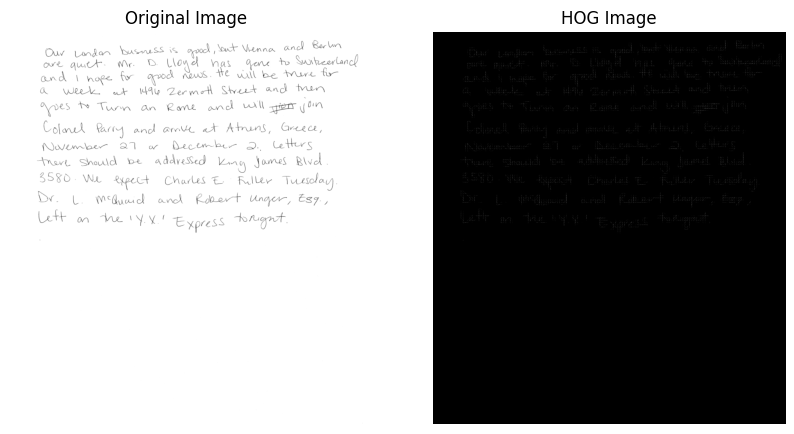

In [29]:
import numpy as np
import cv2
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt

def compute_gradients(img):
    # 1. Compute horizontal and vertical gradients
    g_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=1)
    g_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=1)
    
    # 2. Compute gradient magnitude and orientation
    magnitude = np.sqrt(g_x**2 + g_y**2)
    orientation = np.arctan2(g_y, g_x) * (180 / np.pi) % 180  # Convert radians to degrees and make positive
    
    return magnitude, orientation

def create_histograms(magnitude, orientation, cell_size=(8, 8), num_bins=9):
    # Initialize histograms grid
    cell_rows = magnitude.shape[0] // cell_size[0]
    cell_cols = magnitude.shape[1] // cell_size[1]
    histograms = np.zeros((cell_rows, cell_cols, num_bins))
    
    bin_edges = np.linspace(0, 180, num_bins+1)
    bin_width = bin_edges[1] - bin_edges[0]
    
    for i in range(cell_rows):
        for j in range(cell_cols):
            cell_magnitude = magnitude[i*cell_size[0]:(i+1)*cell_size[0], j*cell_size[1]:(j+1)*cell_size[1]]
            cell_orientation = orientation[i*cell_size[0]:(i+1)*cell_size[0], j*cell_size[1]:(j+1)*cell_size[1]]
            
            # Populate the histogram
            for bin in range(num_bins):
                lower_bound = bin_edges[bin]
                upper_bound = bin_edges[bin+1]
                bin_mask = (cell_orientation >= lower_bound) & (cell_orientation < upper_bound)
                histograms[i, j, bin] = np.sum(cell_magnitude[bin_mask])
    
    return histograms

def visualize_hog(image, filename='hog_visualization.png'):
    fd, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(1, 1), visualize=True, multichannel=True)
    
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    
    plt.figure(figsize=(8, 4))
    plt.subplot(121)
    plt.imshow(image, cmap=plt.cm.gray)
    plt.title('Original Image')
    
    plt.subplot(122)
    plt.imshow(hog_image_rescaled, cmap=plt.cm.gray)
    plt.title('HOG Visualization')
    
    plt.savefig(filename)
    plt.show()

# Load an image in grayscale
image_path = 'w0001_s01_plND_r01.png'
image = cv2.imread(image_path)
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

magnitude, orientation = compute_gradients(preprocessed_image)
histograms = create_histograms(magnitude, orientation)

fd, hog_image = hog(image_gray, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True, feature_vector=True)

# Visualize the HOG image
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(image_gray, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Image')
plt.axis('off')
plt.show()

In [38]:
import os
import cv2
import numpy as np
import pickle
from skimage.feature import local_binary_pattern, hog
from imutils import paths

def extract_features(image_path):
    eps = 1e-7
    numPoints = 24
    radius = 8

    name = image_path.split(os.path.sep)[-1]
    
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Compute the Local Binary Pattern representation of the image,
    # and then use the LBP representation to build the histogram of patterns
    lbp = local_binary_pattern(gray, numPoints, radius, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, numPoints + 3), range=(0, numPoints + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + eps)
    
    # Compute HOG feature vector for the image
    hog_embedding = hog(gray, orientations=8, pixels_per_cell=(16, 16),
                        cells_per_block=(1, 1), block_norm='L2-Hys', visualize=False)
    
    # Combine HOG and LBP embeddings
    embedding = np.append(hog_embedding, hist)
    
    # Print the name and combined embedding
    print("Name:", name)
    print("LBP Embedding:", hist)
    print("HOG Embedding:", hog_embedding)
    print("Combined Embedding:", embedding)

    return hist, hog_embedding, embedding

# Example usage:
image_path = "w0001_s01_pLND_r01.jpeg"
lbp_embedding, hog_embedding, combined_embedding = extract_features(image_path)
print(lbp_embedding.shape, hog_embedding.shape, combined_embedding.shape)


Name: w0001_s01_pLND_r01.jpeg
LBP Embedding: [5.34258666e-04 1.03715683e-03 3.28720232e-04 4.51478238e-04
 4.44838852e-04 5.25782854e-04 5.05158379e-04 7.86414065e-04
 7.97008830e-04 1.22305963e-03 1.03249513e-03 1.61421834e-03
 2.00636590e-03 8.90638296e-03 2.95636313e-03 5.29328569e-03
 3.63188533e-03 7.83391025e-03 4.13633739e-03 7.49106367e-03
 8.27564131e-03 1.90767920e-02 2.88434698e-02 3.88702139e-02
 7.30122385e-01 1.23275314e-01]
HOG Embedding: [0. 0. 0. ... 0. 0. 0.]
Combined Embedding: [0.         0.         0.         ... 0.03887021 0.73012239 0.12327531]
(26,) (219800,) (219826,)
